In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gensim.models.keyedvectors as word2vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

### Import data
# Read data
train_df = pd.read_csv('../../data/train.csv')
test_df = pd.read_csv('../../data/test.csv')
print(train_df.dtypes)

train_df.head(1)

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0


In [23]:
# Split data
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
list_sentences_train = train_df["comment_text"]
list_sentences_test = test_df["comment_text"]

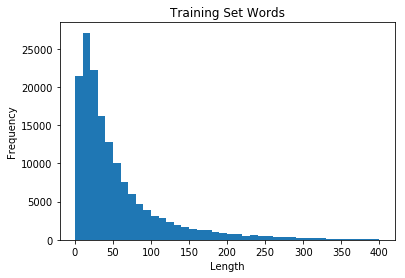

In [24]:
# Text tokenization
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

# Explore sentence lengths
numWord = [len(comment) for comment in list_tokenized_train]
plt.hist(numWord, bins=np.arange(0,410,10))
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Training Set Words')
plt.show()

In [26]:
# Pad tokenization
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test  = pad_sequences(list_tokenized_test,  maxlen=maxlen)

In [29]:
### Model Construction:
# Input(1x200) -> Embedding(200, 128) -> LSTM(200, 60) -> Max Pooling
# -> Dropout(60) -> Dense(50) -> Dropout(50) -> Dense(6)

inp = Input(shape=(maxlen, ))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(6, activation='sigmoid')(x)

model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 60)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [31]:
### Train model
batch_size = 32
epochs = 2
model.fit(X_train,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 954s 7ms/step - loss: 0.0704 - acc: 0.9775 - val_loss: 0.0483 - val_acc: 0.9821
Epoch 2/2
143613/143613 [==============================] - 1208s 8ms/step - loss: 0.0454 - acc: 0.9832 - val_loss: 0.0486 - val_acc: 0.9824


In [32]:
from keras.models import load_model

model.save('../../trained_model/basic_ltsm_keras/pc_net.h5')